# STOP!!! READ THIS FIRST
You should only look at these solutions once you think you have working solutions of your own :).

## Section 6 - Estimating uncertainties
This section details how you can estimate uncertainties on your data if you don't have any or you don't trust what you have.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
plt.rc("font", size=24)
plt.rc("errorbar", capsize=3)

## Exercise 10 - $\chi^2$s from exercises 1 and 2
Here we calculate the $\chi^2$ values from the first two exercises.

In [2]:
#Get the data. We only want x, y and the error on y
_, x_all, y_all, sigy_all, _, _ = np.genfromtxt("data.txt", unpack=True, delimiter='&', skip_header=1)
N_data = len(x_all)
def get_all_data():
    return x_all, y_all, sigy_all

def get_good_data():
    #Points 4 onward
    return x_all[4:], y_all[4:], sigy_all[4:]

def get_bad_data():
    #Points 0 through 3
    return x_all[:4], y_all[:4], sigy_all[:4]

In [3]:
#Make a function that takes in some x, y, sigy and returns b and m
def get_bm(x, y, sigy):
    C = np.diag(sigy**2)
    Cinv = np.linalg.inv(C)
    A = np.vstack((np.ones_like(x), x)).T
    cov = np.linalg.inv(np.dot(A.T, np.dot(Cinv, A)))
    b, m = np.dot(cov, np.dot(A.T, np.dot(Cinv, y)))
    return b, m

#Make a function that takes in x, y, sigy, b, m and returns a chi2
def get_chi2(x, y, sigy):
    b, m = get_bm(x, y, sigy)
    C = np.diag(sigy**2)
    Cinv = np.linalg.inv(C)
    A = np.vstack((np.ones_like(x), x)).T
    cov = np.linalg.inv(np.dot(A.T, np.dot(Cinv, A)))
    DIFF = y - np.dot(A, np.array([b, m]))
    return np.dot(DIFF, np.dot(Cinv, DIFF))

x, y, sigy = get_good_data()
print "Exercise 1 chi2 = %.2f/%d DOF"%(get_chi2(x, y, sigy), len(x))
x, y, sigy = get_all_data()
print "Exercise 2 chi2 = %.2f/%d DOF"%(get_chi2(x, y, sigy), len(x))

Exercise 1 chi2 = 18.68/16 DOF
Exercise 2 chi2 = 289.96/20 DOF


Including the bad data makes the $\chi^2$ horrible.

## Exercise 11 - estimating the error
In this exercise we estimate the error on the data points assuming that they all have the same variance $S$.

(200.0, 1500.0)

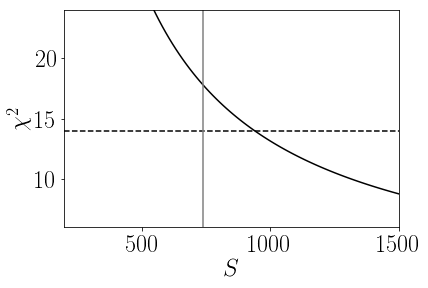

In [4]:
x, y, sigy = get_good_data()
S = np.linspace(200, 1500, 100)
Ss = np.sqrt(S)
chi2s = np.array([get_chi2(x, y, np.ones_like(x)*Ssi) for Ssi in Ss])
plt.plot(S, chi2s, c='k')
plt.axhline(len(x)-2, c='k', ls='--')
plt.axvline(np.mean(sigy**2), c='gray', ls='-')
plt.xlabel(r"$S$")
plt.ylabel(r"$\chi^2$")
plt.ylim(6, 24)
plt.xlim(min(S), max(S))

The $S$ that results in $\chi^2=N-2$ is larger than the mean variance of the data (gray).

## Exercise 12 - modeling $S$
In this exercise we estimate the error on the data points assuming that they all have the same variance $S$, but we also find the posterior on $S$ by writing down a likelihood and sampling it with an MCMC.

The probability of the $i$th point is
$$
p(y_i|x_i, m, b, S) = \frac{1}{\sqrt{2\pi S}} \exp\left(-\frac{[y_i-mx_i-b]^2}{2S} \right)
$$
and we can sample this probability for all points using an MCMC to explore the $m$, $b$, $S$ parameter space.

In [5]:
#Write our likelihood. First step is a prior
def lnprior(params):
    m, b, S = params
    if m < 0 or b < -100: return -np.inf
    if S < 0: return -np.inf
    return 0

#Now a probability
def lnprob(params, x, y):
    m, b, S = params
    N = len(y)
    model = m*x + b
    chi2 = (y-model)**2/S
    return -0.5*(chi2.sum() + N*np.log(2*np.pi*S))

#Now the total likelihood
def lnlike(params, x, y):
    lp = lnprior(params)
    if not np.isfinite(lp): return -np.inf
    return lp + lnprob(params, x, y)

guess = [2.2, 30., 30**2]
x, y, sigy = get_good_data()
print lnlike(guess, x, y)

-76.4511301934


In [6]:
#Optimize with scipy
x, y, sigy = get_good_data()
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guess, args=(x, y), method='Powell')
best_guess = result['x']

In [7]:
#Use emcee to do an MCMC
import emcee
ndim, nwalkers = 3, 20
nsteps = 10000
pos = [best_guess + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y))
output = sampler.run_mcmc(pos, nsteps)

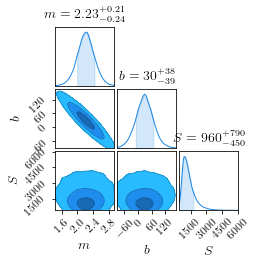

In [8]:
#Visualize, this time with chainconsumer
from chainconsumer import ChainConsumer
fullchain = sampler.flatchain
nburn = 1000
chain = fullchain[int(nwalkers*nburn):]
fig = ChainConsumer().add_chain(chain, parameters=[r"$m$", r"$b$", r"$S$"]).plot()

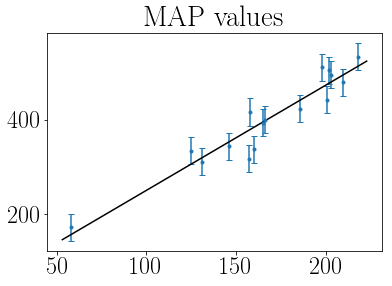

In [9]:
#Plot with the MAP value
likes = sampler.flatlnprobability
m, b, S = fullchain[np.argmax(likes)]
x, y, sigy = get_good_data()
x2 = np.linspace(min(x)-5, max(x)+5, 50)
line = m*x2 + b
plt.errorbar(x, y, np.ones_like(x)*np.sqrt(S), ls='', marker='.')
plt.plot(x2, line, c='k')
plt.title("MAP values")

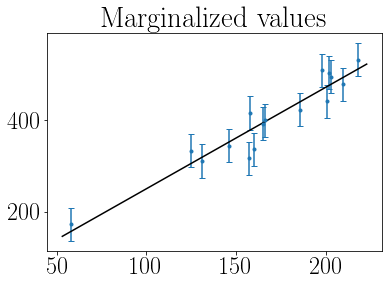

In [10]:
#Plot with the marginalized values
m, b, S = np.mean(chain, 0)
x, y, sigy = get_good_data()
x2 = np.linspace(min(x)-5, max(x)+5, 50)
line = m*x2 + b
plt.errorbar(x, y, np.ones_like(x)*np.sqrt(S), ls='', marker='.')
plt.plot(x2, line, c='k')
plt.title("Marginalized values")